# Text Clustering y Topic Modeling con embeddings
En esta práctica vamos a utilizar un [dataset de artículos científicos](https://huggingface.co/datasets/MaartenGr/arxiv_nlp) y básandonos en los abstract vamos a intentar agrupar estos artículos en diferentes topics/temas.

Ejemplo extraido de *Alammar, J., & Grootendorst, M. (2024). Hands-on large language models: language understanding and generation. " O'Reilly Media, Inc."*.



##Text Clustering

In [ ]:
# Cargamos el dataset que vamos a usar para el text clustering
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]


# Extraemos los abstracts y títulos de los artículos científicos
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
from sentence_transformers import SentenceTransformer

# Creamos un embedding por cada abstract
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)
embeddings.shape

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

(44949, 384)

In [ ]:
from umap import UMAP
# Reducimos el tamaño de los embeddings de 384 a 5 con UMAP.
umap_model = UMAP(
n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
from hdbscan import HDBSCAN
# Entrenamos el modelo y extraemos los clusters
hdbscan_model = HDBSCAN(
min_cluster_size=50, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_
# ¿Cuántos clusters hemos generado?
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


155

In [ ]:
import numpy as np
# Visualizamos los 3 primeros documentos del cluster 0.
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(abstracts[int(index)][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [ ]:
import pandas as pd
# Ahora reducimos de 384 a 2 dimensiones paraque sea más fácil visualizarlos.
reduced_embeddings = UMAP(
  n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

# Creamos un dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Selecionamos los clusters y los outliers
to_plot = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(np.float64(-8.334335255622864),
 np.float64(11.817492890357972),
 np.float64(-5.973596382141113),
 np.float64(11.185701179504395))

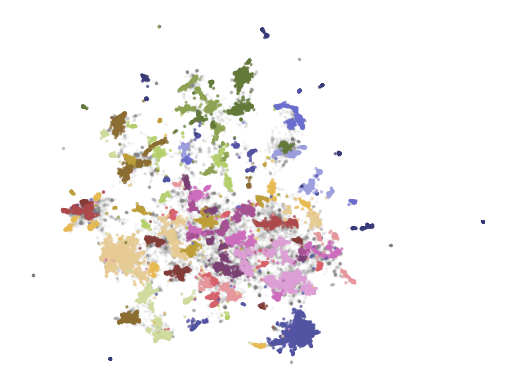

In [ ]:
import matplotlib.pyplot as plt
# Visualizamos por separado los outliers y los clusters
plt.scatter(outliers.x, outliers.y, alpha=0.05, s=2, c="grey")
plt.scatter(
  to_plot.x, to_plot.y, c=to_plot.cluster.astype(int),
  alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")

##Topic Modeling con BERTopic

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.6 MB/s eta 0:00:00


In [ ]:
from bertopic import BERTopic
# Creamos nuestro pipeline de BERTopic
topic_model = BERTopic(
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  verbose=True
).fit(abstracts, embeddings)


2025-11-05 16:21:27,525 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-05 16:23:07,532 - BERTopic - Dimensionality - Completed ✓
2025-11-05 16:23:07,539 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-05 16:23:10,707 - BERTopic - Cluster - Completed ✓
2025-11-05 16:23:10,736 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-05 16:23:20,823 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14210                               -1_of_the_and_to   
1        0   2316                   0_speech_asr_recognition_end   
2        1   2183                 1_question_qa_questions_answer   
3        2    941                 2_translation_nmt_machine_bleu   
4        3    880  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
150    149     54          149_sentence_embeddings_sts_embedding   
151    150     54            150_gans_gan_adversarial_generation   
152    151     54         151_coherence_discourse_paragraph_text   
153    152     53                   152_chatgpt_its_openai_tasks   
154    153     52    153_opinion_reviews_summaries_summarization   

                                        Representation  \
0    [of, the, and, to, in, we, language, for, that...   
1    [speech, asr, recognition, end, acoustic, spea...   
2    [question, qa, questions, answer, answering, a...   
3    [translation, nmt, machine, bleu, neural, engl...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
150  [sentence, embeddings, sts, embedding, similar...   
151  [gans, gan, adversarial, generation, generativ...   
152  [coherence, discourse, paragraph, text, cohesi...   
153  [chatgpt, its, openai, tasks, has, ai, capabil...   
154  [opinion, reviews, summaries, summarization, r...   

                                   Representative_Docs  
0    [  GPT-$3$ has attracted lots of attention due...  
1    [  The speech chain mechanism integrates autom...  
2    [  Text-based Question Generation (QG) aims at...  
3    [  Recently, the development of neural machine...  
4    [  Sentence summarization shortens given texts...  
..                                                 ...  
150  [  Sentence representation at the semantic lev...  
151  [  Text generation is of particular interest i...  
152  [  While there has been significant progress t...  
153  [  Over the last few years, large language mod...  
154  [  When faced with a large number of product r...  

[155 rows x 5 columns]

from matplotlib import pyplot as plt
_df_0['Topic'].plot(kind='hist', bins=20, title='Topic')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Count'].plot(kind='hist', bins=20, title='Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Topic', y='Count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Topic']
  ys = series['Count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Topic', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topic')
_ = plt.ylabel('Count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Topic']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Topic'}, axis=1)
              .sort_values('Topic', ascending=True))
  xs = counted['Topic']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Topic', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topic')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['Topic'].plot(kind='line', figsize=(8, 4), title='Topic')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Count'].plot(kind='line', figsize=(8, 4), title='Count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
topic_model.get_topic(0)

[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

In [ ]:
topic_model.find_topics("topic modeling")

([24, -1, 38, 32, 84],
 [np.float32(0.9545274),
  np.float32(0.9123676),
  np.float32(0.9080541),
  np.float32(0.9053283),
  np.float32(0.90453553)])

In [ ]:
topic_model.get_topic(24)

[('topic', np.float64(0.06811153301756999)),
 ('topics', np.float64(0.035746717561104396)),
 ('lda', np.float64(0.016020062969070364)),
 ('latent', np.float64(0.013574936227317968)),
 ('documents', np.float64(0.013201698266173009)),
 ('document', np.float64(0.012912590658853182)),
 ('modeling', np.float64(0.012084716289729468)),
 ('dirichlet', np.float64(0.01010281253111858)),
 ('word', np.float64(0.008653858081603273)),
 ('allocation', np.float64(0.007950503995528465))]

In [ ]:
# Visualizamos los temas y los documentos relacionados
fig = topic_model.visualize_documents(
  [t for t in titles],
  reduced_embeddings=reduced_embeddings,
  width=1200,
  hide_annotations=True
)
fig.update_layout(font=dict(size=16))

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_heatmap(n_clusters=30)

topic_model.visualize_hierarchy()

### Re-Ranking con KeyBERTInspired

In [ ]:
# Guardamos las representaciones originales (qué palabras son las más importantes por cada tema)
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [ ]:
def topic_differences(model, original_topics, nr_topics=5):
  """Show the differences in topic representations between two models """
  df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
  for topic in range(nr_topics):
    # Extraer las 5 palabras clave más importantes por tema
    og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
    new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
    df.loc[len(df)] = [topic, og_words, new_words]
  return df

In [ ]:
from bertopic.representation import KeyBERTInspired

# Actualizamos las representaciones de cada uno de los temas usando KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Mostramos las diferencia pre-KeyBERTInspired y post-KeyBERTInspired
topic_differences(topic_model, original_topics, 7)

Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1     question | qa | questions | answer | answering   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   
5      5      gender | bias | biases | debiasing | fairness   
6      6    relation | extraction | re | relations | entity   

                                             Updated  
0  phonetic | encoder | transcription | speech | ...  
1  answering | comprehension | questions | questi...  
2  translation | translate | translations | trans...  
3  summarization | summarizers | summaries | summ...  
4  hate | hateful | language | offensive | languages  
5         gendered | gender | bias | biases | biased  
6  relations | relation | relational | extracting...

### Re-Ranking con Maximal Marginal Relevance

In [ ]:
from bertopic.representation import MaximalMarginalRelevance

# Cambiamos el método de re-ranking para que haya más diversidad
representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Comparamos con el enfoque inicial
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1     question | qa | questions | answer | answering   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0           speech | asr | audio | error | automatic  
1  questions | retrieval | comprehension | passag...  
2       translation | nmt | bleu | neural | parallel  
3  summarization | summaries | extractive | docum...  
4       hate | offensive | toxic | abusive | hateful

### Generación de etiquetas que representa cada tema

In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the documents and keywords, what is this topic about?"""

# Actualizamos la representación con la que mostramos cada tema
generator = pipeline("text2text-generation", model="google/flan-t5-small")
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Comparamos con el enfoque inicial
topic_differences(topic_model, original_topics)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
100%|██████████| 155/155 [01:30<00:00,  1.72it/s]


Topic                                           Original  \
0      0        speech | asr | recognition | end | acoustic   
1      1     question | qa | questions | answer | answering   
2      2        translation | nmt | machine | bleu | neural   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                  Updated  
0  Speech-to-speech synthesis |  |  |  |   
1  Question answering systems |  |  |  |   
2                Science/Tech |  |  |  |   
3      Document summarization |  |  |  |   
4                Science/Tech |  |  |  |